<a href="https://colab.research.google.com/github/meghnaparsan/StyleTransferVGG/blob/master/StyleTransferVGG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

print (tf.__version__)

1.15.0


In [ ]:
tf.enable_eager_execution()

In [ ]:
content_image = plt.imread ("/content/drive/My Drive/Content_image.jpg")
style_image = plt.imread ("/content/drive/My Drive/Style_image.jpg")

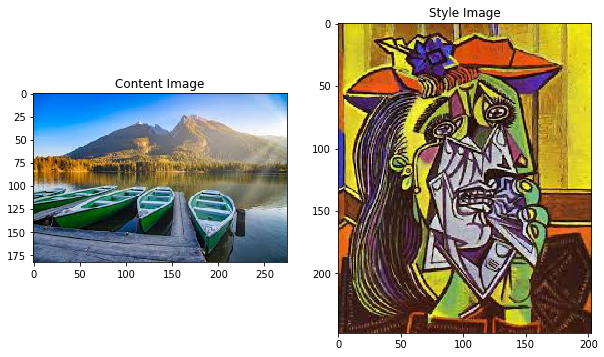

In [ ]:
fig, (ax1, ax2) =plt.subplots (1, 2, figsize = (10, 10))

ax1.imshow (content_image)
ax1.set_title ("Content Image")

ax2.imshow (style_image)
ax2.set_title ("Style Image")

plt.show()

In [ ]:
def load_image (image):
  image_read = plt.imread (image)
  image_tensor = tf.image.convert_image_dtype (image_read, tf.float32)
  image_tensor = tf.image.resize (image_tensor, [400, 400])
  image_tensor = image_tensor [tf.newaxis, :]
  return image_tensor

In [ ]:
content_tensor = load_image("/content/drive/My Drive/Content_image.jpg")
style_tensor = load_image ("/content/drive/My Drive/Style_image.jpg")

print (content_tensor.shape)
print (style_tensor.shape)

(1, 400, 400, 3)
(1, 400, 400, 3)


In [ ]:
vggModel = tf.keras.applications.VGG19 (include_top = False, weights = "imagenet")

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
vggModel.trainable = False

In [ ]:
for layer in vggModel.layers:
  print (layer.name)

input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block4_conv2']

style_layers = ['block1_conv1,
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

In [ ]:
number_content_layers = len (content_layers)
number_style_layers = len (style_layers)

In [ ]:
def mini_model(layer_names, model):
  outputs = [model.get_layer(name).output for name in layer_names]
  model = Model ([vggModel.input], outputs)
  return model

In [ ]:
def gram_matrix(tensor):
  temp = tensor
  temp = tf.squeeze (temp) #removes all 1s
  featureMap = tf.reshape (temp, [temp.shape [2], temp.shape [0] * temp.shape [1]])
  result = tf.matmul (temp, temp, transpose_b = True)
  gram = tf.expand_dims (result, axis = 0)
  return gram

In [ ]:
class Style_Model (tf.keras.models.Model):
  def __init__ (self, style_layers, content_layers):
    super (Style_Model, self).__init__()
    self.vggModel = mini_model (style_layers + content_layers, vggModel)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.number_style_layers = len (style_layers)
    self.vggModel.trainable = False

  def call (self, inputs):
    inputs = inputs * 255.0
    preprocessed_input = preprocess_input (inputs)
    outputs = self.vggModel (preprocessed_input)
    
    style_outputs, content_outputs = (outputs[:self.number_style_layers],
                                        outputs[self.number_style_layers:])

    style_outputs = [gram_matrix (style_output) for style_output in style_outputs]

    content_dictionary = {content_name : value 
                            for content_name, value
                            in zip (self.content_layers, content_outputs)}
                      
    style_dictionary = {style_name : value
                          for style_name, value
                          in zip (self.style_layers, style_outputs)
                          }

    return {'content' : content_dictionary, 'style' : style_dictionary}

In [ ]:
extractor = Style_Model (style_layers, content_layers)

In [ ]:
style_targets = extractor(style_tensor)['style']
content_targets = extractor(content_tensor)['content']

In [ ]:
optim = tf.keras.optimizers.Adam (learning_rate = 0.02)

In [ ]:
style_weight = 100
content_weight = 10

style_weights = {'block1_conv1' : 1.,
                 'block2_conv1' : 0.8,
                 'block3_conv1' : 0.5,
                 'block4_conv1' : 0.3,
                 'block5_conv1' : 0.1,
}

In [ ]:
def total_loss (outputs):
  style_outputs = outputs ['style']
  content_outputs = outputs ['content']

  style_loss = tf.add_n ([style_weights[name] * tf.reduce_mean ((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])

  style_loss *= style_weight / number_style_layers

  content_loss = tf.add_n ([tf.reduce_mean ((content_outputs[name] - content_targets [name]) ** 2) for name in content_outputs.keys()])

  content_loss *= content_weight / number_content_layers

  loss = style_loss + content_loss
  return loss

In [ ]:
@tf.function()

def train_step (image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = total_loss(outputs)

  grad = tape.gradient(loss, image)
  optim.apply_gradients ([(grad, image)])
  image.assign (tf.clip_by_value (image, clip_value_min = 0.0, clip_value_max = 1.0))

In [ ]:
target_image = tf.Variable (content_tensor)

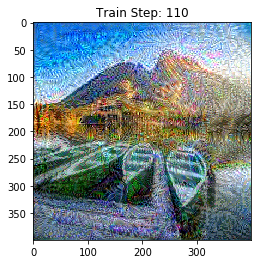

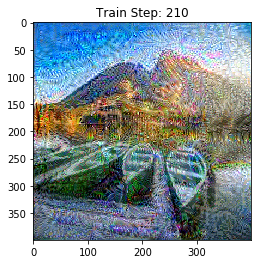

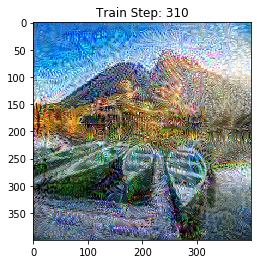

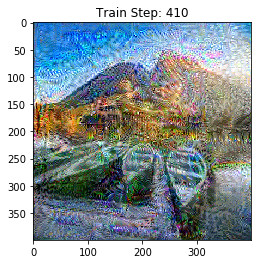

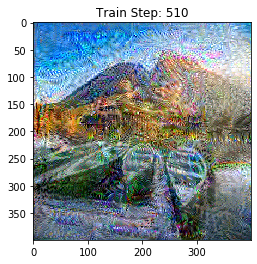

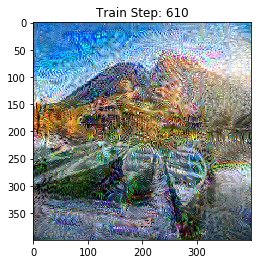

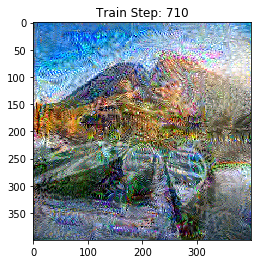

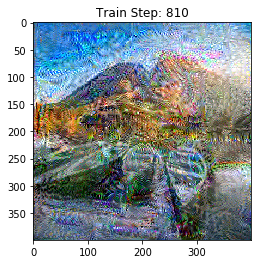

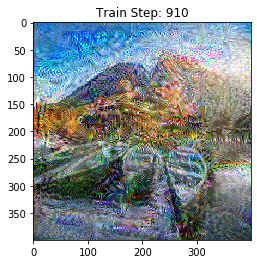

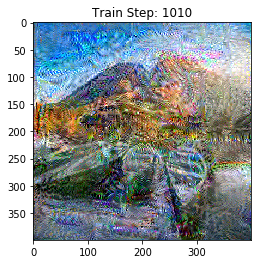

In [ ]:
epochs = 10
steps_per_epoch = 100

step = 10

for n in range (epochs):
  for m in range (steps_per_epoch):
    step += 1
    train_step (target_image)

  plt.imshow (np.squeeze (target_image.read_value(), 0))
  plt.title ("Train Step: {}".format(step))
  plt.show()